### Imports

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import copy

### Set path label for file reading
This is the YYYYMMDD_CVD_XXXX label at the beginning of the XRF map folder.

In [3]:
path_label = "20230531_CVD_3158"

### File reading

#### Bruker
File format is a space-separated table. Annoyingly, multiple spaces are used to separate some columns, instead of tabs, which is what any reasonable person would do.

The first element in each row is the filename. The second is total Si counts, the third is total P counts, then Ar, Ni, Zn, Ga, Rh.

This routine reads every line in the file, ignoring them if they don't contain data; splits them at spaces, removes empty strings, and writes counts data to arrays at a position dictated by the grid position specified by the file name.

In [17]:
source = "Bruker"

input_file = open("./" + path_label + "_map/" + path_label + "_60s_10x10pts_roi_net_sum.txt", "r")

sample_name = "CVD" + path_label[-4:]

#dat["Xx_dY"] contains data from element Xx, detector y
dat = {
    "Si_d1": np.zeros((10, 10)),
    "Si_d2": np.zeros((10, 10)),
    "Ga_d1": np.zeros((10, 10)),
    "Ga_d2": np.zeros((10, 10))
}

#how this works: readline returns a single empty string ONLY IF the EOF is reached
s = input_file.readline().split(" ") 
while s != [""]:

    if s[0][0] == "2": #check if it's a line containing data - 
                       #the line starts with the filename, which starts with the
                       #year, which starts with a 2
                       #this will break if you are using the script in the 31st
                       #century

        for i in range(len(s)-1, -1, -1):
            #run through list and delete empty strings
            #must run through backwards because if you go forwards, the length
            #will shrink over the course of the loop and it will go out of
            #range

            #empty strings could be avoided with split() with no delimiter, but
            #then the script wouldn't be able to distinguish between "\n" and ""
            #because split() has the same return value for both of those
            if s[i] == "":
                del s[i]
                
        x = int(s[0][-3]) #x is the slower changing index
        y = int(s[0][-1]) #y is the most rapidly changing index
        si_counts = float(s[1])
        ga_counts = float(s[6])
        if s[0][-5] == "1": #separate into detector 1 and detector 2
            dat["Si_d1"][x][y] = si_counts
            dat["Ga_d1"][x][y] = ga_counts
            
        elif s[0][-5] == "2":
            dat["Si_d2"][x][y] = si_counts
            dat["Ga_d2"][x][y] = ga_counts
               
    s = input_file.readline().split(" ")
        
input_file.close()

vec = dat.copy()
#TODO: copying etc.----------------------------------------------------------------------------------------
for key, val in vec.items():
    vec[key] = val.reshape(100)

In [20]:
vec["Si_d1"].shape

(100,)

#### Bruker, with added background
The file format is the same as described above, but this routine also reads the background data spreadsheet and adds the background data back into the map.

#### PyMca
Format is ;-separated csv file. First row is headers. The first two columns are a row and column entry. PyMca assumes that your data are in a grid but it doesn't know how our data are arranged, so it just dumps them all into a list of rows. Thankfully, the list has all our data ordered 0_0, 0_1, 0_2, etc. This means the row number can be used to determine the x and y coordinates of the spectrum with a bit of math. The y coordinate is row # mod 10, and the x coordinate is (row number / 10) mod 10.

### Statistical Processing
This routine calculates the average and standard deviation of the data. It also trims off data with z-scores too far from zero and calculates the average and standard deviation of those as well.

In [4]:
trim_threshold = 2

def getStats(ar, thr):
    """calculate and return statistical properties of ar

    ar will be trimmed to remove data with |z| > thr

    ar must be a 1d array
    """
    av = np.average(ar)
    std = np.std(ar)

    z = np.abs((ar - av) / std) # z-score of each element of ar
    mask = np.invert(np.array(z//thr, dtype=bool)) #mask[i] is true only if z[i] >= thr
    trim = ar[mask] #trim includes only elements ar[i] such that z[i] >= thr

    av_trim = np.average(trim)
    std_trim = np.std(trim)

    return av, std, av_trim, std_trim

#format string to be used for writing to files and stdio
row_format = "{0}\t{1}\t{2[0]:.0f}\t{2[1]:.0f}\t{2[2]:.0f}\t{2[3]:.0f}"

print(sample_name + " Statistics, " + source)
print("Trim threshold: z >= " + str(trim_threshold))
print("\t\t\t\ttrimmed\ttrimmed")
print("Signal\tDet.\tAvg\tSTD\tavg\tstd")

print(row_format.format("Si", "d1", getStats(vec_si_d1, trim_threshold)))
print(row_format.format("Si", "d2", getStats(vec_si_d2, trim_threshold)))
print(row_format.format("Ga", "d1", getStats(vec_ga_d1, trim_threshold)))
print(row_format.format("Ga", "d2", getStats(vec_ga_d2, trim_threshold)))

#write results to file
stats_out_file = open("./" + path_label + "_map/results_out/" + path_label + "_stats_" + source + ".txt", "w")

stats_out_file.write(sample_name + " Statistics, " + source + "\n")
stats_out_file.write("Trim threshold: z >= " + str(trim_threshold) + "\n")
stats_out_file.write("\t\t\t\ttrimmed\ttrimmed\n")
stats_out_file.write("Signal\tDet.\tAvg\tSTD\tavg\tstd\n")

#write() needs a \n at the end
stats_out_file.write(row_format.format("Si", "d1", getStats(vec_si_d1, trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Si", "d2", getStats(vec_si_d2, trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d1", getStats(vec_ga_d1, trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d2", getStats(vec_ga_d2, trim_threshold)) + "\n")

stats_out_file.close()

CVD3158 Statistics, Bruker
Trim threshold: z >= 2
				trimmed	trimmed
Signal	Det.	Avg	STD	avg	std
Si	d1	339937	1164	340076	900
Si	d2	354071	1351	354305	1003
Ga	d1	13131	131	13131	112
Ga	d2	13430	144	13430	130


### Probability plots
This routine makes normal probability plots for the data. These can be used to assess if the data is normally distributed or not. It's also just a good way to visualize the distribution.

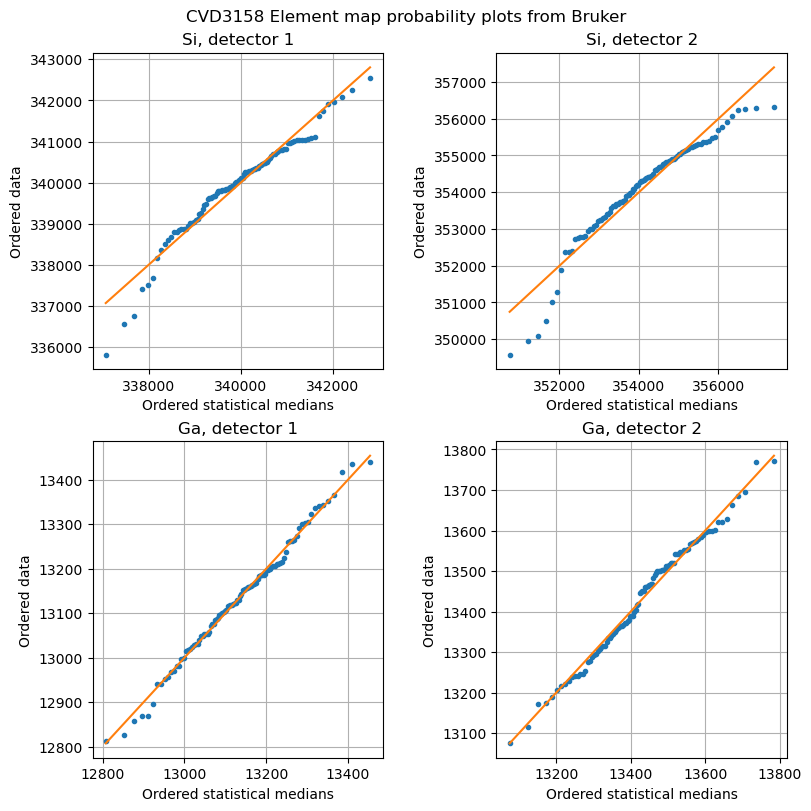

In [12]:
def probPlot(ax, dat, title):
    
    osm, osr = stats.probplot(dat, (np.average(dat), np.std(dat)), dist="norm", fit=False)
    ax.plot(osm, osr, ".") #plot data
    ax.plot(osm, osm, "-") #plot line y=x
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel("Ordered statistical medians")
    ax.set_ylabel("Ordered data")

f, ((ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=2, ncols = 2, figsize = (8, 8), layout="constrained")

probPlot(ax7, vec_si_d1, "Si, detector 1")
probPlot(ax8, vec_si_d2, "Si, detector 2")
probPlot(ax9, vec_ga_d1, "Ga, detector 1")
probPlot(ax10, vec_ga_d2, "Ga, detector 2")

f.suptitle(sample_name + " Element map probability plots from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_prob_plots_" + source + ".png",
            dpi="figure",
            format="png")

### Heatmap
This routine plots the data using contourf().

In [ ]:
c="viridis"
fg, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 8), layout="constrained")

def drawMap(a, dat, cm, title):
    """draw contour plot
    dat is array of data to draw
    a is axes on which to draw it
    cm is the color map to use
    title is the title to write
    """
    im_pointer = a.contourf(dat, levels = 10, extent = [0, 15, 0, 15], cmap = cm)
    plt.colorbar(im_pointer, ax=a)
    a.set_title(title)

drawMap(ax1, dat_si_d1, c, "Si intensity, detector 1")
drawMap(ax2, dat_si_d2, c, "Si intensity, detector 2")

drawMap(ax3, dat_ga_d1, c, "Ga intensity, detector 1")
drawMap(ax4, dat_ga_d2, c, "Ga intensity, detector 2")

fg.suptitle(sample_name + " maps from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_intensity_map_" + source + ".png",
            dpi="figure",
            format="png")

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right